In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import stephane.display.graphes as graphes
import stephane.elasticity.processing as proc
import fluids2d.backlight as bl
import pims
import fluids2d.piv as piv
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import stephane.cine.cine as cine
import stephane.tools.Smath as Smath
import scipy.interpolate as interp

In [71]:
folder = '/media/stephane/DATA/Experimental_data/Turbulence3d/20181010/'
l =glob.glob(folder+'*.cine')
print(l[1])
cinefile = l[1]
os.path.basename(cinefile)

/media/stephane/DATA/Experimental_data/Turbulence3d/20181010/PIV3dscan_nikon50mm_f1kHz_A800mV_offsetm2800mV_rotator.cine


'PIV3dscan_nikon50mm_f1kHz_A800mV_offsetm2800mV_rotator.cine'

95944


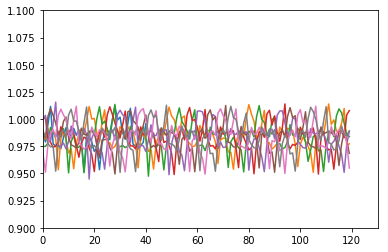

In [72]:
c = pims.open(cinefile)
print(c.len())

N=75000
C = []
for i in range(50000,51000):
    if True:
    #    if np.mod(i,10000)<120:
        norm = np.sum(c.get_frame(i)**2,axis=(0,1))
        C.append(np.sum(c.get_frame(i)*c.get_frame(i+1),axis=(0,1))/norm)
        if np.mod(i,120)==0:
            plt.plot(C)
            plt.axis([0,130,0.9,1.1])
            C = []

2.5e-05
0.0


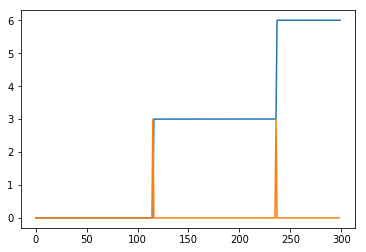

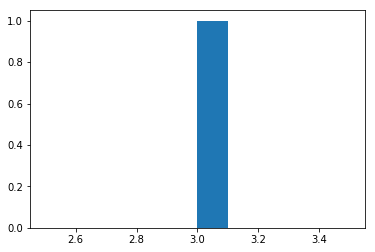

In [65]:
c=cine.Cine(cinefile)
timages =   np.asarray([c.get_time(i) for i in range(300)])
plt.plot(timages)
plt.plot(np.diff(timages))

tnew= timages[:-1]
indices = np.logical_and(np.diff(timages)>1.,np.diff(timages)<5)

print(1/40000.)

waittime = np.diff(tnew[indices])

plt.figure()
plt.hist(waittime)

print(np.max(waittime)-np.min(waittime))

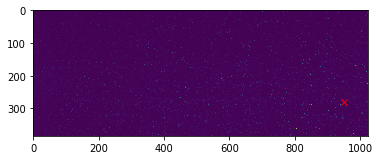

In [10]:
plt.imshow(c.get_frame(0))
plt.plot([950],[280],'rx')

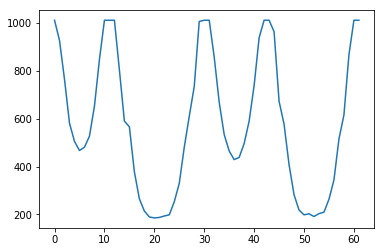

In [17]:
N=31*2
x = np.zeros(N)
for i in range(N):
    x[i]=c.get_frame(i)[280,950]
plt.plot(x)

In [47]:
parent_folder = '/media/stephane/' 
date = '20181102'
cine_name = l[2]
data_folder = 'DATA/Experimental_data/Turbulence3d/'+date+'/test'
save_folder = data_folder+ '/test1/'

dx =  0.35E-03#7.3469357156E-05
dt_orig = 1./40000

crop_lims=None
pre_constructed_masker = None
t0 = 0
a_frames = np.arange(t0,10000+t0,1)
frame_diff = 40

window_size = 32
overlap = 16

processing = piv.PIVDataProcessing(parent_folder,cine_name,name_for_save=data_folder,dx=dx,dt_orig=dt_orig,frame_diff=frame_diff,crop_lims=crop_lims,maskers=None,window_size=window_size,overlap=overlap,search_area_size=32)
processing.associate_flowfield()
ff = processing.data.ff

dx : 
0.00035
dt_ab: 
0.001


In [48]:
ff.shape

(119960, 23, 63, 2)

In [49]:
 #convert 2d to 3d data
(Nt,Nx,Ny,Nc) = ff.shape
ff = np.reshape(ff,(int(Nt/frame_diff),frame_diff,Nx,Ny,Nc))

#keep only one way volume scan
#ff = ff[...]

ff[...,1] = -ff[...,1] #reverse sign of horizontal component
print(ff.shape)

(Nz,Nx,Ny,Nc) = mean_flow.shape
print(mean_flow.shape)

(2999, 40, 23, 63, 2)
(40, 23, 63, 2)


In [50]:
#compute mean_flow
mean_flow = np.nanmean(ff,axis=0)
mean_flow_speed = np.linalg.norm(mean_flow,axis=2)
mean_speed = np.nanmean( np.sqrt(ff[...,0]**2 + ff[...,1]**2 ), axis=0)
fluc = ff - mean_flow    
u_rms = np.sqrt(np.nanmean(fluc[...,0]**2+fluc[...,1]**2 ,axis=0) )

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


24


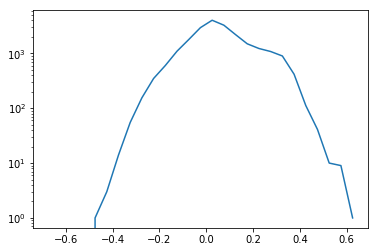

In [158]:
t0 = 1100

print(np.sum(np.isnan(fluc[t0,2:18,:-1,:-1,0])))

[n,x] = np.histogram(np.ndarray.flatten(fluc[t0,2:18,:-1,:-1,0]),np.arange(-0.7,0.7,0.05))
x = (x[1:]+x[:-1])/2
plt.semilogy(x,n)

In [165]:
def display_correlation(t,C):
    plt.subplot(1,3,1)
    plt.plot(t,C)
    plt.axis([-250,250,-0.2,1.05])
    graphes.legende('Time (ms)','$<u(t)u(t+\Delta t) >_{x,y,z}$','')

    plt.subplot(1,3,2)
    plt.plot(t,C)
    plt.axis([-75,75,0.75,1.05])
    graphes.legende('Time (ms)','','')

    plt.subplot(1,3,3)
    plt.plot(t,C)
    plt.axis([-15,15,0.9,1.01])
    graphes.legende('Time (ms)','','')

Total number of frames processed : 2500


/home/stephane/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Volume with less than 5% error : 1062


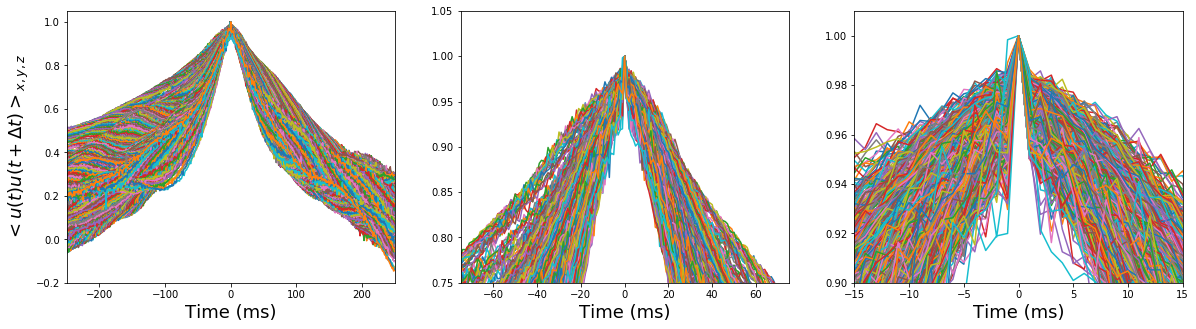

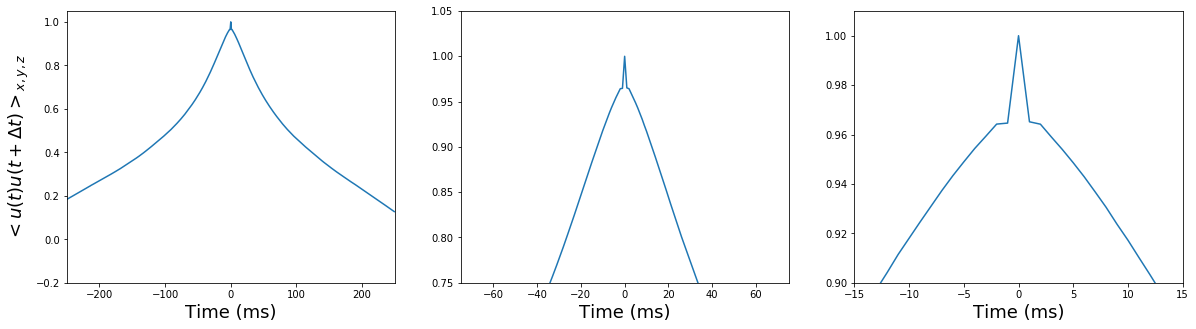

In [307]:
fig,axs=plt.subplots(1,3,figsize=(20,5))

good_frame = []
Ct = []
error = []
tlist = range(250,2750,1)
print("Total number of frames processed : "+str(len(tlist)))

for t0 in tlist:
    ff2 = np.nanmean(fluc[t0,2:18,...,0]**2,axis=(0,1,2))
    C = []
    t = np.arange(t0-250,t0+250,1)
    
    C0 = np.nanmean(fluc[t0+1,2:18,...,0]*fluc[t0,2:18,...,0],axis=(0,1,2))/ff2
    error.append(1-C0)
    if C0>0.95:  
        for tc in t:
#    print(tc)
            C0 = np.nanmean(fluc[tc,2:18,...,0]*fluc[t0,2:18,...,0],axis=(0,1,2))/ff2
            C.append(C0) 
        display_correlation(t-t0,C)        
        Ct.append(C)
        good_frame.append(t0)
Ct = np.asarray(Ct)

print("Volume with less than 5% error : "+str(Ct.shape[0]))
Ctmean = np.nanmean(Ct,axis=0)
tmean = t-t0

fig,axs=plt.subplots(1,3,figsize=(20,5))
display_correlation(tmean,Ctmean)

[1500, 1600, 0, 0.8]

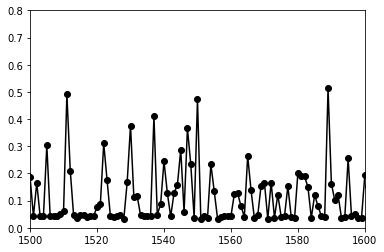

In [315]:
plt.plot(tlist,error,'ko-')
plt.axis([1500,1600,0,0.8])

In [211]:
print(fluc.shape)

(2999, 40, 23, 63, 2)


Correlation time (ms) : 91ms


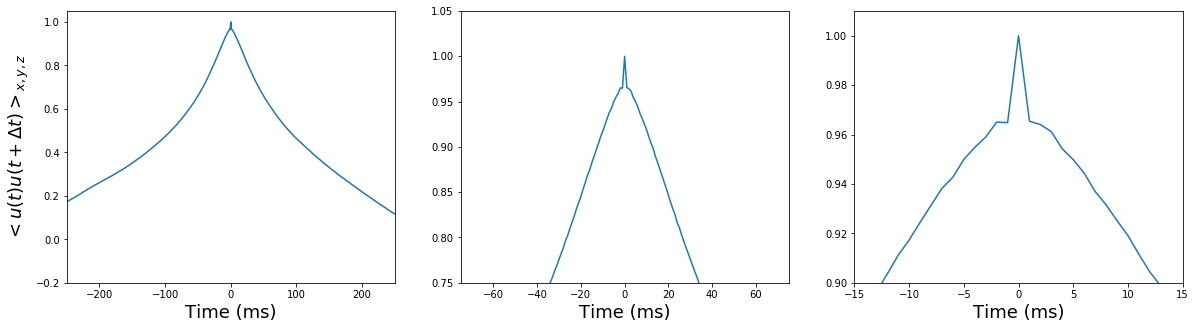

In [178]:
fig,axs=plt.subplots(1,3,figsize=(20,5))
display_correlation(tmean,Ctmean)

i = np.argmin(np.abs(Ctmean-0.5))
print('Correlation time (ms) : '+str(np.abs(tmean[i])) +' ms')

In [341]:
1024/384
41/17

2.411764705882353

In [213]:
#generate axis
(Nz,Nx,Ny,Nc) = mean_flow.shape
#mean_flow = np.transpose(mean_flow,(1,2,0,3))

dz = 42/20
x = np.arange(-(Nx-1)/2,(Nx-1)/2+1)*processing.dx*1E3*overlap+5
y = np.arange(-(Ny-1)/2,(Ny-1)/2+1)*processing.dx*1E3*overlap-120
z = np.arange(-Nz/2,Nz/2)*dz-2

#invariance by rotation in the plane (x,z)

[X,Z,Y] = np.meshgrid(x,z,y)
print(X.shape)

(40, 23, 63)


In [255]:
Xv = X[2:18,:-1,:-1]
Yv = Y[2:18,:-1,:-1]
Zv = Z[2:18,:-1,:-1]

flucv = fluc[:,2:18,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

#j0 = 4
print(Xv.shape)

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

R = np.sqrt((Xv-x0)**2+(Yv-y0)**2+(Zv-z0)**2)

ff2u = np.nanmean(flucv[good_frame,k0,i0,j0,0]**2)
ff2v = np.nanmean(flucv[good_frame,k0,i0,j0,1]**2)

Cmapu = flucv[good_frame,...,0]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,0],(Nz,Nx,Ny,1)),(3,0,1,2))
Cmapv = flucv[good_frame,...,1]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,1],(Nz,Nx,Ny,1)),(3,0,1,2))

print(Cmapu.shape)

(16, 22, 62)
(1062, 16, 22, 62)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


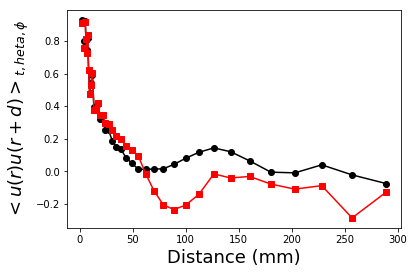

In [259]:
dlist = np.logspace(0,np.log10(np.max(R)),50)

Cdu = []
Cdv = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[:,indices])/ff2u
    C0v = np.nanmean(Cmapv[:,indices])/ff2v

    Cdu.append(C0u)
    Cdv.append(C0v)
    
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')

fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')

(16, 22, 62)
(1062, 16, 22, 62)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


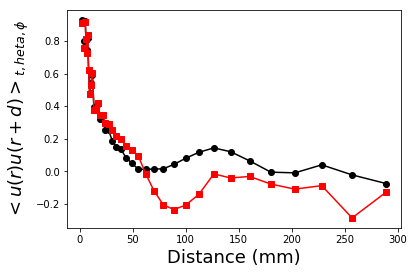

In [260]:
Xv = X[2:18,:-1,:-1]
Yv = Y[2:18,:-1,:-1]
Zv = Z[2:18,:-1,:-1]

flucv = fluc[:,2:18,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

j0 = 4
print(Xv.shape)

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

R = np.sqrt((Xv-x0)**2+(Yv-y0)**2+(Zv-z0)**2)

ff2u = np.nanmean(flucv[good_frame,k0,i0,j0,0]**2)
ff2v = np.nanmean(flucv[good_frame,k0,i0,j0,1]**2)

Cmapu = flucv[good_frame,...,0]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,0],(Nz,Nx,Ny,1)),(3,0,1,2))
Cmapv = flucv[good_frame,...,1]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,1],(Nz,Nx,Ny,1)),(3,0,1,2))

print(Cmapu.shape)
dlist = np.logspace(0,np.log10(np.max(R)),50)

Cdu = []
Cdv = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[:,indices])/ff2u
    C0v = np.nanmean(Cmapv[:,indices])/ff2v

    Cdu.append(C0u)
    Cdv.append(C0v)
    
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')

fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')

In [25]:
Xv = X[2:18,:-1,:-1]
Yv = Y[2:18,:-1,:-1]
Zv = Z[2:18,:-1,:-1]

flucv = fluc[:,2:18,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

j0 = 4
#i0 = 20

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

[R,Theta] = Smath.cart2pol(Xv-x0,Yv-y0)
#R = np.sqrt((Xv-x0)**2+(Yv-y0)**2)


ff2u = np.nanmean(flucv[good_frame,:,i0,j0,0]**2)
ff2v = np.nanmean(flucv[good_frame,:,i0,j0,1]**2)

Cmapu = flucv[good_frame,...,0]*np.transpose(np.tile(flucv[good_frame,:,i0,j0,0],(Nx,Ny,1,1)),(2,3,0,1))
Cmapv = flucv[good_frame,...,1]*np.transpose(np.tile(flucv[good_frame,:,i0,j0,1],(Nx,Ny,1,1)),(2,3,0,1))

print(Cmapu.shape)
dlist = np.logspace(np.log10(1),np.log10(np.max(R)),50)

Cdu = []
Cdv = []
Cd = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[...,indices])
    C0v = np.nanmean(Cmapv[...,indices])
    
    Cd.append((C0u+C0v)/(ff2u+ff2v))
#    C0l = 
#    C0t = 
    Cdu.append(C0u/ff2u)
    Cdv.append(C0v/ff2v)

fig,axs=plt.subplots(1,2,figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(dlist[:-1],Cd,'bo-')
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.axis([0,50,0,1])
fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')
                  
plt.subplot(1,2,2)
plt.plot(dlist[:-1],Cd,'bo-')
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.plot(dlist,np.zeros(len(dlist)),'k--')
plt.axis([0,300,-0.5,1])
fig = graphes.legende('Distance (mm)','','')

NameError: name 'X' is not defined

In [300]:
Ek = np.abs(np.fft.fftshift(np.fft.fftn(fluc[good_frame,2:18,:-1,:-1,0]**2,axes=(1,2,3)),axes=(1,2,3)))

In [338]:
print(Ek.shape)
np.sum(np.isnan(np.ndarray.flatten(Ek)))

(1062, 16, 22, 62)


23046144

(16, 22, 62)
[]
[]
[]
[]
[]
[]
[]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
[]
[]
[]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
[]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


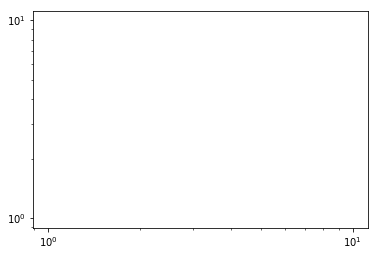

In [336]:
(Nt,Nz,Nx,Nt) = Ek.shape

kx = np.linspace(-Nx//2,Nx//2,Nx)
ky = np.linspace(-Ny//2,Ny//2,Ny)
kz = np.linspace(-Nz//2,Nz//2,Nz)

[Kx,Kz,Ky] = np.meshgrid(kx,kz,ky)
print(Kx.shape)

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)

Klist = np.logspace(0,np.log10(np.max(K)),50)
E1d = []
for i,k0 in enumerate(Klist[:-1]):
    indices = np.logical_and(K>=Klist[i],K<Klist[i+1])
    print(Ek[250,indices])
    val = np.nanmean(Ek[250,indices])
    E1d.append(val)

print(E1d)
plt.loglog(Klist[:-1],E1d,'ko-')
#plt.loglog(Klist,100*Klist**(-5./3),'r-')

In [266]:
a = np.ones((299,40))
np.transpose(np.tile(a,(23,63,1,1)),(2,3,0,1)).shape

(299, 40, 23, 63)

1475


[1200, 1750, -0.2, 1.05]

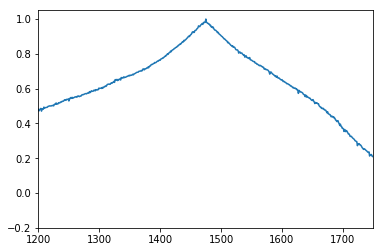

In [111]:
t = np.arange(0,2950,1)
n = len(t)
t0 = t[(n+1)//2]
print(t0)
ff2 = np.nanmean(fluc[t0,2:18,...,1]**2,axis=(0,1,2))
C = []
for tc in t:
#    print(tc)
    C.append(np.nanmean(fluc[tc,2:18,...,1]*fluc[t0,2:18,...,1],axis=(0,1,2))/ff2) 
plt.plot(t,C)
plt.axis([1200,1750,-0.2,1.05])

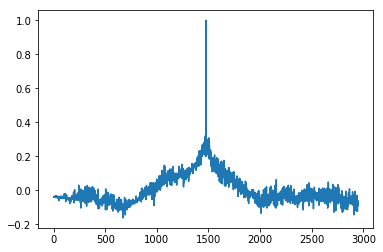

In [28]:
print(mean_flow.shape)
print(X[:,:,:].shape)

(40, 23, 63, 2)
(40, 23, 63)


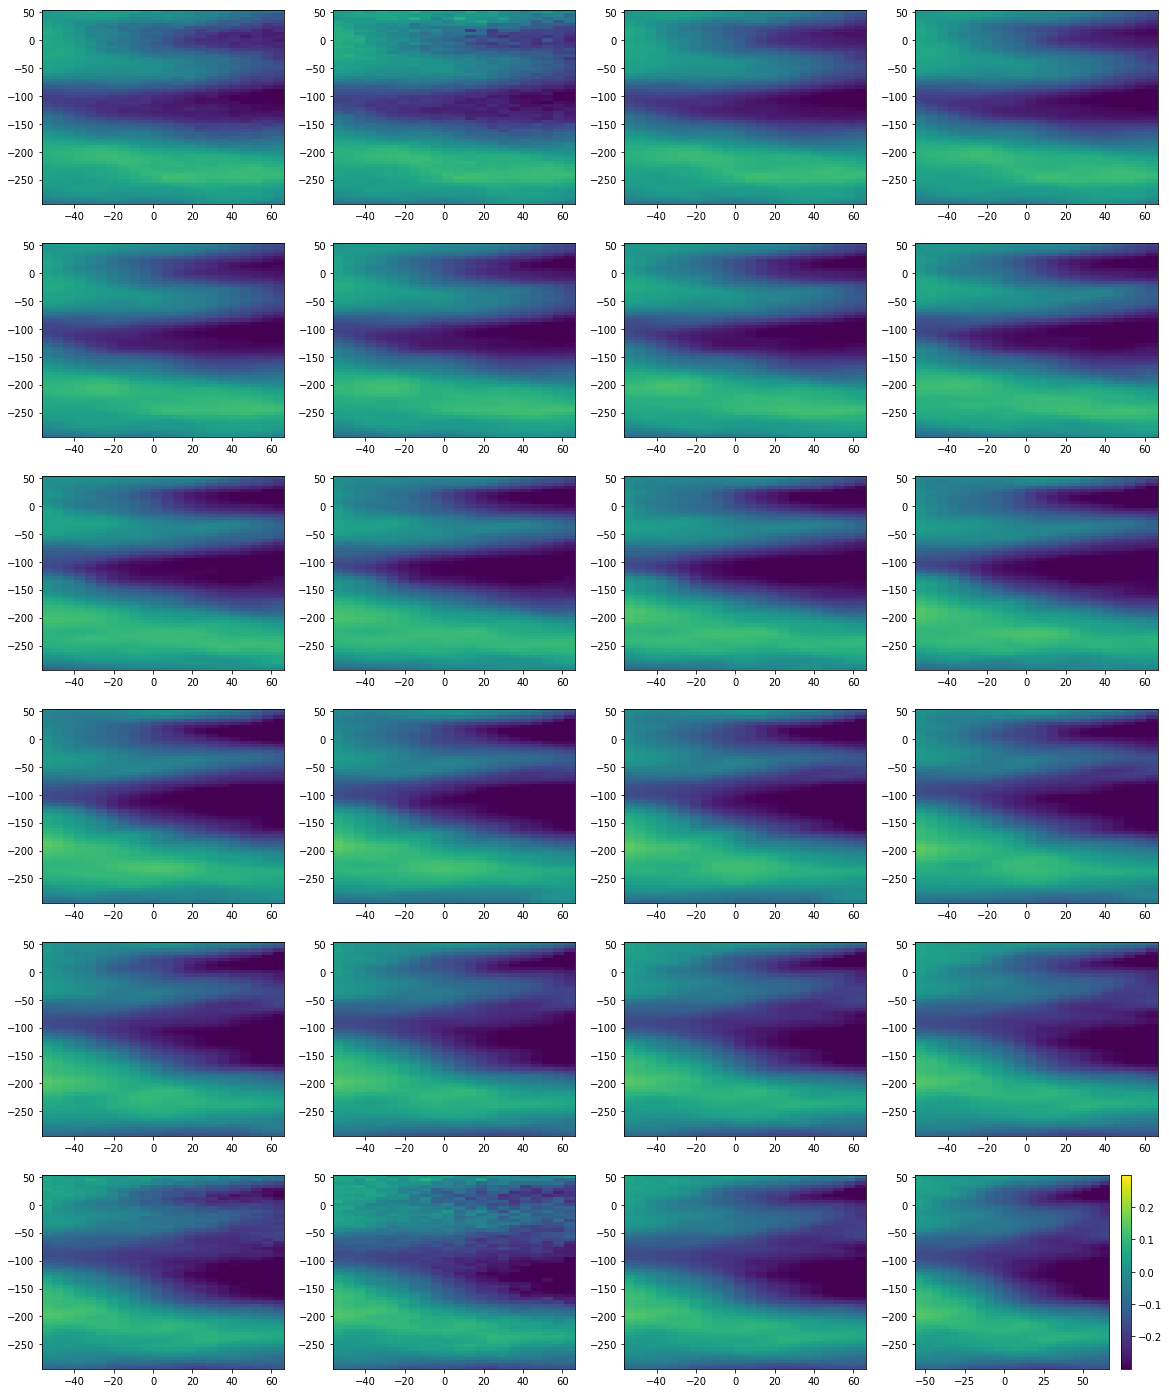

In [55]:
fig,axs=plt.subplots(6,4,figsize=(20,25))

for i in range(6):
    for j in range(4):
        plt.subplot(6,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],mean_flow[i*4+j,...,1],vmin=-0.3,vmax=0.3)
#    plt.colorbar()
plt.colorbar()

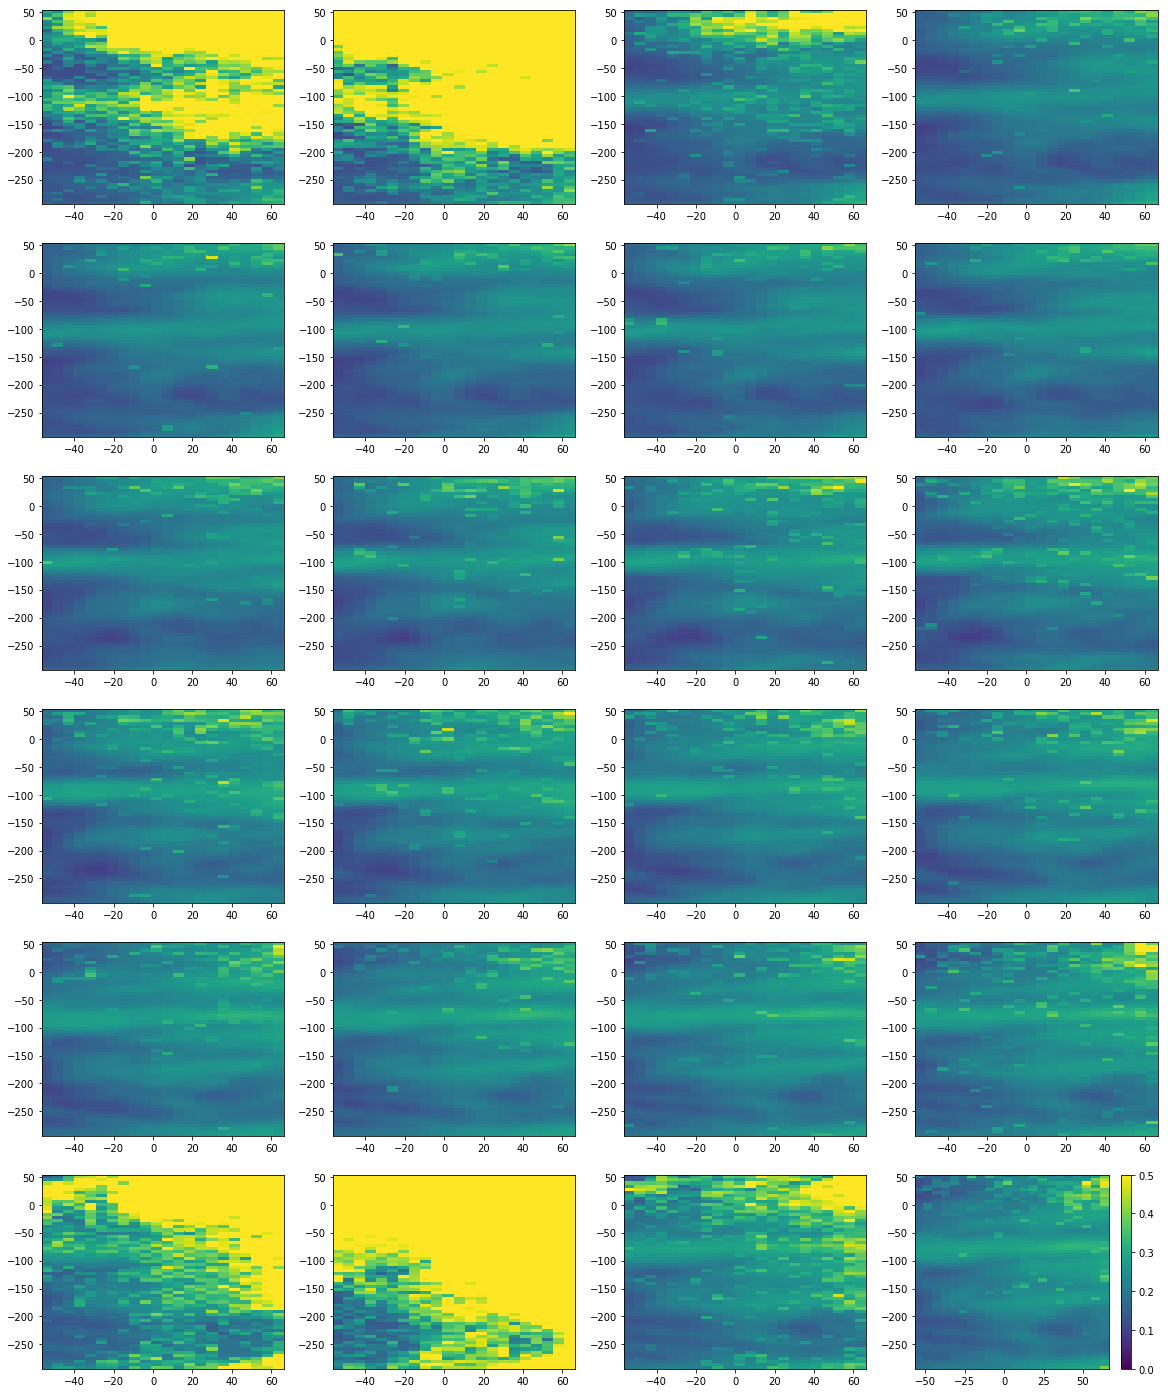

In [54]:
fig,axs=plt.subplots(6,4,figsize=(20,25))

for i in range(6):
    for j in range(4):
        plt.subplot(6,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],u_rms[i*4+j,...],vmin=0,vmax=0.5)
plt.colorbar()

(23, 63)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


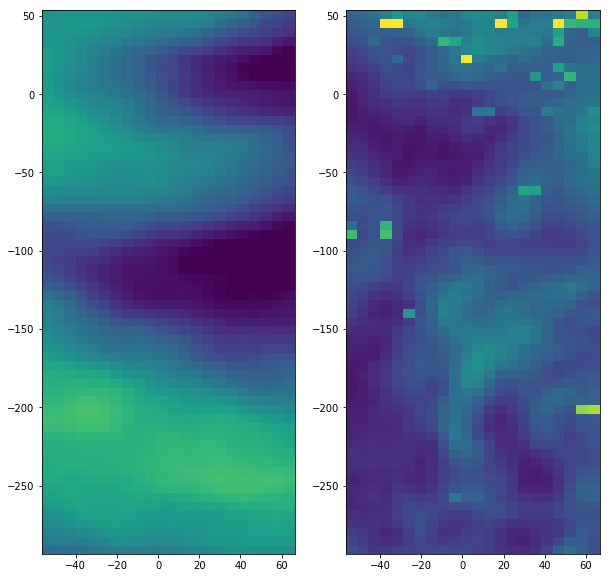

In [68]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
print(mean_flow[10,...,0].shape)
axs[0].pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

axs[1].pcolormesh(X[0,...],Y[0,...],np.nanmean(fluc[:,6,...,0]**2,axis=0),vmin=0,vmax=0.05)
#plt.colorbar()

In [338]:
[R,Theta] = Smath.cart2pol(X,Z)
Ur = 2*mean_flow[...,1]*np.cos(Theta)  #coefficient to be compensated by the circle fraction avalaible, so the coeff is r dependent
Utheta = -2*mean_flow[...,1]*np.sin(Theta) #average along Theta still required

fur = interp.RegularGridInterpolator((z,x,y),Ur,method='linear',bounds_error=False,fill_value=np.nan)
fut = interp.RegularGridInterpolator((z,x,y),Utheta,method='linear',bounds_error=False,fill_value=np.nan)
fuz = interp.RegularGridInterpolator((z,x,y),mean_flow[...,0],method='linear',bounds_error=False,fill_value=np.nan)

#futheta = interp.RegularGridInterpolator(Utheta, values, method='linear', bounds_error=True, fill_value=nan)[source]


In [248]:
print(Ur.shape)

(16, 31, 63)


In [242]:
helicity = fur((R[:,:,40]*np.cos(Theta[:,:,]),x[5],y[40]))

array([-0.073379  , -0.07342986, -0.06604033, -0.06482857, -0.06580828,
       -0.06344544, -0.05669815, -0.04911837, -0.03393364, -0.02424669,
       -0.01768416, -0.01310526, -0.00867227, -0.00059881,  0.00032977,
        0.00036066])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


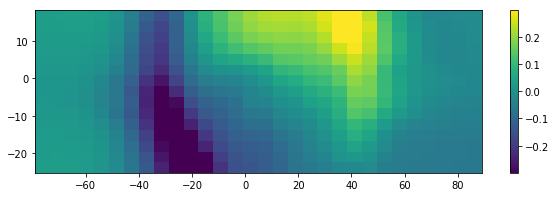

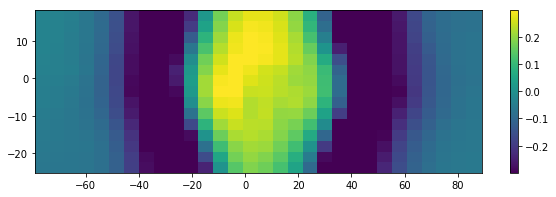

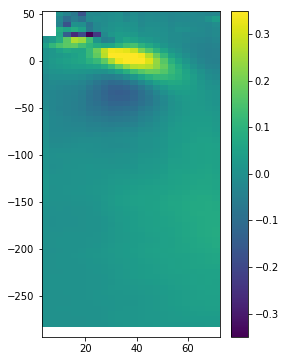

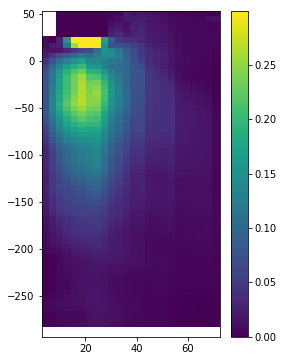

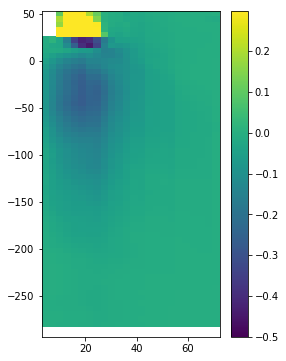

In [340]:
k =52

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,1],vmin=-0.3,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,0],vmin=-0.3,vmax=0.3)
plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Ur[...,k],vmin=-0.3,vmax=0.3)
dtheta = 2*np.pi/50
theta = np.arange(np.pi/2,2*np.pi+np.pi/2,dtheta)
dr = dz
R0 = np.arange(dz,dz*(Nx-5),dz)
Nr = len(R0)

#plt.plot(np.min(R0)*np.cos(theta),np.min(R0)*np.sin(theta),'r')
#plt.plot(np.max(R0)*np.cos(theta),np.max(R0)*np.sin(theta),'r')

UR = np.zeros((Ny,Nr))
UT = np.zeros((Ny,Nr))
UZ = np.zeros((Ny,Nr))

for i in range(len(y)):
    for j,r0 in enumerate(R0):
        UR[i,j] = np.nanmean(fur((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UT[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UZ[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
    

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UR,vmin=-0.35,vmax=0.35)
plt.colorbar()


fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,-UT,vmin=0.,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UZ,vmin=-0.5,vmax=0.3)
plt.colorbar()

y
#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Utheta[...,k],vmin=-0.3,vmax=0.3)
#plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(5,8))
#plt.pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

In [192]:
#definition of mask
x0 = 175
y0 = 130
width = 120
height = 50

ValueError: cannot reshape array of size 31248 into shape (1,63)

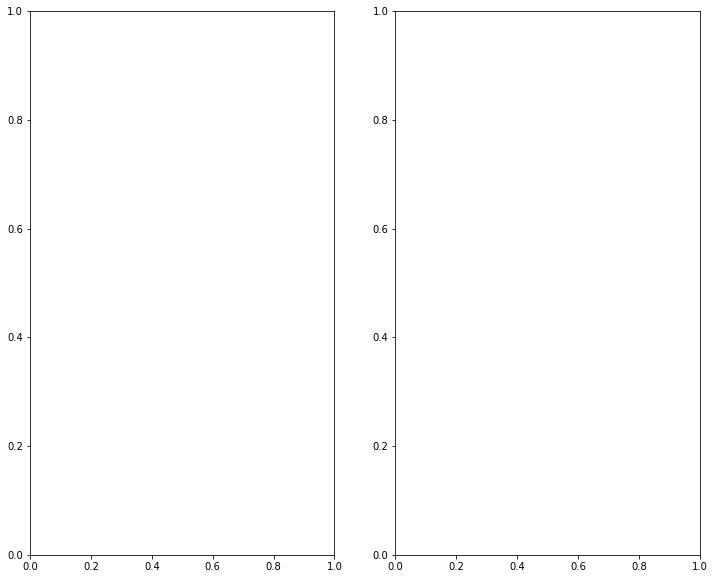

In [121]:
fig,axs=plt.subplots(1,2,figsize=(12,10)); axs=axs.flatten()
cax=[]
c=[]
j = 10
#for i in range(2):
#    divider = make_axes_locatable(axs[i])
#    cax.append(divider.append_axes('right', size='10%', pad=0.1))
    
for (i,data) in zip(range(2),[mean_speed[j,:,:],u_rms[j,:,:]]):
    #axs[i].clear()
    cb=axs[i].pcolormesh(X,Y,data,vmin=0,vmax=0.4)
#            cb=axs[i].pcolormesh(X,Y,ff[0,j,:,:,1],vmin=0,vmax=0.3)
#    fig.colorbar(cb)
#    c.append(fig.colorbar(cb, cax=cax[i], orientation='vertical'))

    axs[0].set_title(r'$y = '+str(int(z[j]))+' mm')
        #axs[1].set_title(r'$\bar u_{rms}$')

    axs[0].set_xlabel('$z$ (mm)')
    axs[i].set_xlabel('$x$ (mm)')
    #c[0].set_label(r'$\bar u$ (m/s)')
    #c[0].set_label(r'$\bar u_{rms}$ (m/s)')
    
    p=patches.Rectangle((x0,y0),width,height,facecolor='w',edgecolor='r')
    axs[i].add_patch(p)